In [2]:
import time
import os
import random
import csv
import numpy as np
import pandas as pd
from itertools import chain
from pdp_lib import processing as proc
from pdp_lib import util
from GA_lib import GA_multi_depot as GA
from GA_lib import operation_multi_depot as operation
from GA_lib import evaluate_multi_depot as evaluate


In [3]:
def solve_and_print(filename,rounds = 10,population_size = 100,generations=2000,crossoverRate=1.0,mutationRate=0.5):
    process_time = time.time()
    numVehicles, LoadCapacities, speed, data = proc.load_file(filename)
    LOCATIONS = data[0]
    DEMANDS = data[1]
    timeWindows = data[2]
    serviceTimes = data[3]
    pickupSiblings = data[4]
    deliverySiblings = data[5]
    requestType = data[6]
    REQUESTS  = proc.generate_request(pickupSiblings, deliverySiblings, requestType)
    DISTANCES = proc.createDistanceTable(LOCATIONS)
    DURATIONS = proc.createDurationTable(LOCATIONS, DISTANCES, serviceTimes, speed)
    DEPOTS = proc.create_depots(LOCATIONS)
    DISTANCES_FROM_DEPOTS = proc.distances_from_depots(DEPOTS, LOCATIONS)
    DISTANCES_TO_DEPOTS = proc.distances_to_depots(DEPOTS, LOCATIONS)
    DEPOT_NUMBERS = proc.simple_assign_depots(REQUESTS, LOCATIONS, DEPOTS, DISTANCES_FROM_DEPOTS, DISTANCES_TO_DEPOTS)
    REQ_BY_DEPOTS = proc.requests_by_depots(DEPOTS, REQUESTS, DEPOT_NUMBERS)

    print('----------------Instance name: '+str(filename)+'-----------------------------------')
    print(" processing time --- %s seconds ---" % (time.time() - process_time))

    total_results = []
    for round in range(rounds):
        results_all_depots = []
        distance_all_depots = []
        time_all_depots = []
        # print('#################### Round :' +str(round+1)+' ############################')
        for id_depot in range(len(DEPOTS)):
            THIS_DEP_REQS = REQ_BY_DEPOTS[id_depot]
            NODES_OF_THIS_DEPOT = proc.locations_of_this_depot(id_depot, REQ_BY_DEPOTS, LOCATIONS)
            # ############### SOLVING THE PROBLEMS !!!!!!!! ######################################
            pops_create_time = time.time()
            calculation_time = time.time()
            # print('#################### DEPOT :' +str(id_depot)+' ############################')
            ## Initialize the populations
            populations = []
            for _ in range(population_size):
                chromosome = GA.initialize_Feasible_chromosome(DISTANCES, DISTANCES_FROM_DEPOTS, DISTANCES_TO_DEPOTS, id_depot, DURATIONS, timeWindows, THIS_DEP_REQS, DEMANDS, LoadCapacities)
                populations.append(chromosome)
            # print("Populations creation time --- %s seconds ---" % (time.time() - pops_create_time))
            ## Crossovers and mutate ##
            GA_time = time.time()

            ## Evaluate fitnesses of all populations ##
            best_fitness_so_far = -99999999
            for gen in range(generations):
                fitness_table = []
                for chromosome in populations:
                    fitness_table.append(
                        evaluate.chromosomeFitness(chromosome, DISTANCES, DISTANCES_FROM_DEPOTS, DISTANCES_TO_DEPOTS,
                                                   id_depot))
                populations = [x for _, x in sorted(zip(fitness_table, populations), reverse=True)]
                populations.pop()
                populations.pop()
                elite1 = populations.pop(0)
                elite2 = populations.pop(0)


                ## Tournament Selection ##
                # id1, id2 = random.randrange(0, len(populations)), random.randrange(0, len(populations))
                id1,id2,id3,id4 = random.sample(range(0, len(populations)), 4)
                fitness1,fitness2,fitness3,fitness4 = fitness_table[id1],fitness_table[id2],fitness_table[id3],fitness_table[id4]
                candidate1,candidate2,candidate3,candidate4 = populations[id1], populations[id2],populations[id3],populations[id4]
                parent1 = operation.tournament_selection(candidate1,candidate2,fitness1,fitness2)
                parent2 = operation.tournament_selection(candidate3,candidate4,fitness3,fitness4)

                ## Crossing over !! ####
                child1, child2 = operation.crossover(DISTANCES, DURATIONS, timeWindows, THIS_DEP_REQS, parent1, parent2,
                                                     DEMANDS, LoadCapacities, DISTANCES_FROM_DEPOTS,
                                                     DISTANCES_TO_DEPOTS, id_depot, crossoverRate)
                # if(not evaluate.haveEqualNodes(child1,child2,LOCATIONS)):
                #         print('note have Equal nodes, Crossover Bug!!!!!'+ str(gen))
                #         break
                #
                ## Mutation ##
                child1 = operation.mutate(child1, DISTANCES, DURATIONS, timeWindows, THIS_DEP_REQS, DEMANDS,
                                          LoadCapacities, DISTANCES_FROM_DEPOTS, DISTANCES_TO_DEPOTS, id_depot, mutationRate)
                child2 = operation.mutate(child2, DISTANCES, DURATIONS, timeWindows, THIS_DEP_REQS, DEMANDS,
                                          LoadCapacities, DISTANCES_FROM_DEPOTS, DISTANCES_TO_DEPOTS, id_depot, mutationRate)
                if (not evaluate.haveEqualNodes(child1, child2, NODES_OF_THIS_DEPOT)):
                    print('note have Equal nodes, Mutation Bug!!!!!' + str(gen))
                    break


                ## Evaluate Fitness of the best ones ###
                current_fitness = evaluate.chromosomeFitness(child1, DISTANCES, DISTANCES_FROM_DEPOTS,
                                                             DISTANCES_TO_DEPOTS, id_depot)
                current_fitness = max(current_fitness,
                                      evaluate.chromosomeFitness(child2, DISTANCES, DISTANCES_FROM_DEPOTS,
                                                                 DISTANCES_TO_DEPOTS, id_depot))
                current_fitness = max(current_fitness,
                                      evaluate.chromosomeFitness(elite1, DISTANCES, DISTANCES_FROM_DEPOTS,
                                                                 DISTANCES_TO_DEPOTS, id_depot))
                current_fitness = max(current_fitness,
                                      evaluate.chromosomeFitness(elite2, DISTANCES, DISTANCES_FROM_DEPOTS,
                                                                 DISTANCES_TO_DEPOTS, id_depot))

                ## Add them back into populations ###
                populations.append(child1)
                populations.append(child2)
                populations.append(elite1)
                populations.append(elite2)

                ### Check break conditions ####
                if (current_fitness > best_fitness_so_far):
                    best_fitness_so_far = current_fitness
                    bestFitGen = gen
                    # print('#### New Best Fitness !! , Best so far is :' + str(10000.0 / best_fitness_so_far) + '#####')
                    # print('#### This Generation: ' + str(gen) + '#######')
                if (gen - bestFitGen >= 500):
                    # print('#### Break Generation: ' + str(gen) + '#######')
                    break
                # print('############# Round-'+str(round+1) +',DEPOT-'+str(id_depot)+','+ 'Generation:' + str(gen + 1) + ' #########################')
                # print('This Gen Distance :' + str(10000.0 / current_fitness))

            ### Evaluate results of current DEPOT ####
            fitness_table = []
            for chromosome in populations:
                fitness_table.append(
                    evaluate.chromosomeFitness(chromosome, DISTANCES, DISTANCES_FROM_DEPOTS, DISTANCES_TO_DEPOTS, id_depot))
            populations = [x for _, x in sorted(zip(fitness_table, populations), reverse=True)]
            # print("GA time --- %s seconds ---" % (time.time() - GA_time))
            best_chromosome = populations[0]
            computational_time = time.time() - calculation_time
            # print("Total Calculation time --- %s seconds ---" % (computational_time))
            distance = evaluate.chromosomeRoutesDistance(best_chromosome,DISTANCES,DISTANCES_FROM_DEPOTS,DISTANCES_TO_DEPOTS,id_depot)
            # print('Distances of the best chromosome: ' + str(distance))

            ## Memo the results ##
            results_all_depots.append(best_chromosome)
            distance_all_depots.append(distance)
            time_all_depots.append(computational_time)
        total_results.append((results_all_depots,distance_all_depots,time_all_depots))
    return total_results

# The Instances

In [4]:
filename = 'pdp_instances/LiLim/pdp_100/lc105.txt'

# Processing the file

In [125]:

start_time = time.time()
numVehicles, LoadCapacities, speed, data = proc.load_file(filename)
LOCATIONS = data[0]
DEMANDS = data[1]
timeWindows = data[2]
serviceTimes = data[3]
pickupSiblings = data[4]
deliverySiblings = data[5]
requestType = data[6]
REQUESTS = proc.generate_request(pickupSiblings,deliverySiblings,requestType)
DISTANCES = proc.createDistanceTable(LOCATIONS)
DURATIONS = proc.createDurationTable(LOCATIONS, DISTANCES, serviceTimes, speed)
DEPOTS = proc.create_depots(LOCATIONS)
DISTANCES_FROM_DEPOTS = proc.distances_from_depots(DEPOTS,LOCATIONS)
DISTANCES_TO_DEPOTS = proc.distances_to_depots(DEPOTS, LOCATIONS)
DEPOT_NUMBERS = proc.simple_assign_depots(REQUESTS, LOCATIONS, DEPOTS,DISTANCES_FROM_DEPOTS ,DISTANCES_TO_DEPOTS)
REQ_BY_DEPOTS = proc.requests_by_depots(DEPOTS,REQUESTS,DEPOT_NUMBERS)

filepath = filename 
filename = filename.rsplit('/', 1)[1]
filename = filename.split('.')[0]
print( 'Instance name : '+str(filename))
print(" processing time --- %s seconds ---" % (time.time() - start_time))

Instance name : lc105
 processing time --- 0.053002357482910156 seconds ---


# Visualizing the instances

Instance name : lc105
 processing time --- 2.211122989654541 seconds ---


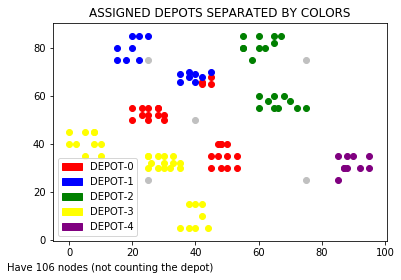

In [129]:
print( 'Instance name : '+str(filename))
print(" processing time --- %s seconds ---" % (time.time() - start_time))
util.draw_simple_assigned_depots(REQUESTS,LOCATIONS,DEPOTS,DEPOT_NUMBERS)

# Solve and print

In [130]:
results = solve_and_print(filepath)

----------------Instance name: pdp_instances/LiLim/pdp_100/lc105.txt-----------------------------------
 processing time --- 0.04800248146057129 seconds ---
#################### Round :1 ############################


#################### Round :2 ############################


#################### Round :3 ############################


#################### Round :4 ############################


#################### Round :5 ############################


#################### Round :6 ############################


#################### Round :7 ############################


#################### Round :8 ############################


#################### Round :9 ############################


#################### Round :10 ############################


# Average Computational times

# Make Average Results

In [140]:
solutions = []
cal_times = []
distances = []
for round,round_result in enumerate(results):
    sol = results[round][0]
    dist = results[round][1]   
    ct = results[round][2]
    
    
    solutions.append(sol)
    distances.append(dist)
    cal_times.append(ct)


In [141]:

distances

[[148.75638455308712,
  98.782327103466329,
  148.51835634154887,
  197.95845011092302,
  52.527300430865452],
 [148.75638455308712,
  98.782327103466329,
  148.51835634154887,
  197.95845011092302,
  52.527300430865452],
 [148.75638455308712,
  98.782327103466329,
  148.51835634154887,
  197.95845011092302,
  52.527300430865452],
 [148.75638455308712,
  98.782327103466329,
  148.51835634154887,
  197.95845011092302,
  52.527300430865452],
 [148.75638455308712,
  98.782327103466329,
  148.51835634154887,
  197.95845011092302,
  52.527300430865452],
 [148.75638455308712,
  98.782327103466329,
  148.51835634154887,
  197.95845011092302,
  52.527300430865452],
 [148.75638455308712,
  98.782327103466329,
  148.51835634154887,
  197.95845011092302,
  52.527300430865452],
 [148.75638455308712,
  98.782327103466329,
  148.51835634154887,
  197.95845011092302,
  52.527300430865452],
 [148.75638455308712,
  98.782327103466329,
  148.51835634154887,
  197.95845011092302,
  52.527300430865452],
 

In [137]:
distances = np.array(distances)
distances = pd.DataFrame(distances)
distances = np.mean(distances,axis=0)
distances

0    148.756385
1     98.782327
2    148.518356
3    197.958450
4     52.527300
dtype: float64

# Average Computational times

In [133]:
cal_times = np.array(cal_times) 
cal_times =pd.DataFrame(cal_times)
cal_times = np.mean(cal_times,axis=0)
cal_times

0    3.375252
1    1.570503
2    1.960836
3    4.052600
4    0.922445
dtype: float64

# Mean Results

In [6]:
def mean_results(results):
    solutions = []
    cal_times = []
    distances = []
    for round,round_result in enumerate(results):
        sol = results[round][0]
        dist = results[round][1]   
        ct = results[round][2]
        
        solutions.append(sol)
        distances.append(dist)
        cal_times.append(ct)
    distances = np.array(distances)
    distances = pd.DataFrame(distances)
    distances = np.mean(distances,axis=0)
    cal_times = np.array(cal_times) 
    cal_times =pd.DataFrame(cal_times)
    cal_times = np.mean(cal_times,axis=0)
    
    return distances,cal_times

# Automated Run Instances

In [8]:
path = 'pdp_instances/LiLim/doing/'
FILENAMES = next(os.walk(path))[2]

all_results = []

for name in FILENAMES:
    filepath = path + name
    results = solve_and_print(filepath)
    distances,cal_times = mean_results(results)
    all_results.append((name,distances,cal_times))
all_results

----------------Instance name: pdp_instances/LiLim/doing/lc201.txt-----------------------------------
 processing time --- 0.11900615692138672 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lc202.txt-----------------------------------
 processing time --- 0.10297346115112305 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lc203.txt-----------------------------------
 processing time --- 0.06900453567504883 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lc204.txt-----------------------------------
 processing time --- 0.0739736557006836 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lc205.txt-----------------------------------
 processing time --- 0.06097078323364258 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lc206.txt-----------------------------------
 processing time --- 0.06300806999206543 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lc207.txt-----------------------------------
 processing time --- 0.056006431579589844 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lc208.txt-----------------------------------
 processing time --- 0.09552741050720215 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lr101.txt-----------------------------------
 processing time --- 0.0610048770904541 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lr102.txt-----------------------------------
 processing time --- 0.06001901626586914 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lr103.txt-----------------------------------
 processing time --- 0.06749367713928223 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lr104.txt-----------------------------------
 processing time --- 0.05201864242553711 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lr105.txt-----------------------------------
 processing time --- 0.07350492477416992 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lr106.txt-----------------------------------
 processing time --- 0.0920403003692627 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lr107.txt-----------------------------------
 processing time --- 0.1275479793548584 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lr108.txt-----------------------------------
 processing time --- 0.06600832939147949 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lr109.txt-----------------------------------
 processing time --- 0.10751986503601074 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lr110.txt-----------------------------------
 processing time --- 0.12751531600952148 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lr111.txt-----------------------------------
 processing time --- 0.07700967788696289 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lr112.txt-----------------------------------
 processing time --- 0.12703466415405273 seconds ---


----------------Instance name: pdp_instances/LiLim/doing/lr201.txt-----------------------------------
 processing time --- 0.05347776412963867 seconds ---


KeyboardInterrupt: 

In [9]:
all_results

[('lc201.txt', 0    247.216798
  1    152.765610
  2    203.816777
  3    259.487907
  4    191.407094
  dtype: float64, 0    2.225919
  1    1.771600
  2    1.825994
  3    5.322303
  4    0.820149
  dtype: float64), ('lc202.txt', 0    249.329910
  1    174.694776
  2    206.866078
  3    267.063232
  4    165.443333
  dtype: float64, 0    2.771356
  1    3.831809
  2    5.306495
  3    9.641229
  4    1.503688
  dtype: float64), ('lc203.txt', 0    232.820554
  1    186.340951
  2    200.691366
  3    253.990259
  4    165.443333
  dtype: float64, 0     2.901572
  1    10.930810
  2     8.768873
  3    10.491483
  4     1.931917
  dtype: float64), ('lc204.txt', 0    236.205555
  1    151.758552
  2    186.030519
  3    252.159030
  4    186.951269
  dtype: float64, 0     6.843116
  1     5.374275
  2     8.584877
  3    57.709153
  4     1.790600
  dtype: float64), ('lc205.txt', 0    289.627202
  1    151.665462
  2    188.763257
  3    245.760773
  4    152.961126
  dtype: float64, 0

In [41]:
all_results

[[3, [31, 30, 28, 29], [57, 55, 54, 53, 56, 58, 60, 59]],
 [2,
  [22, 24, 23, 26, 25, 27, 21],
  [43, 42, 41, 40, 44, 46, 45, 48, 51, 101, 50, 52, 49, 47]],
 [1, [19, 16, 20, 17, 18], [32, 33, 31, 35, 37, 38, 39, 36, 105, 34]]]

# Writing to csv

In [10]:
distances,cal_times = mean_results(results)

In [11]:
distances

0    323.577161
1    240.173247
2    140.756369
3    357.587357
4    177.558213
dtype: float64

In [12]:
cal_times

0     4.968013
1     2.719320
2     0.584586
3    16.220225
4     1.052786
dtype: float64

In [13]:
all_results
# res = np.array(all_results[1])
all_results[5]

('lc206.txt', 0    274.068881
 1    161.742303
 2    219.308464
 3    290.712108
 4    129.975279
 dtype: float64, 0     3.005666
 1     2.431872
 2     8.661901
 3    13.330512
 4     0.615378
 dtype: float64)

# Writing to csv

In [14]:
dist = [dist for _,dist,_ in all_results]
dist = np.array(dist)
df = pd.DataFrame(dist)
df.to_csv('distances_df.csv')

In [33]:
CT = [ct for _,_,ct in all_results]
CT = np.array(CT)
df_CT = pd.DataFrame(CT)
df_CT.to_csv('CT_df.csv')